# **STAGE PONTS INSTRUMENTES - Notebook 15**


## Table of Contents

### 0. [Bibliothèques](#0/-Bibliothèques)
### I. [Préparation des fonctions de la procédure](#I/-Préparation-des-fonctions-de-la-procédure)
### II. [Procédure](#II/-Procédure)
### III. [Décalage sur tous les pics à partir d'une fonction interpolée LI/Speeds](#III/-Décalage-sur-tous-les-pics-à-partir-d'une-fonction-interpolée-LI/Speeds)


**Dans ce Notebook nous allons exécuter les fonctions de la procédure pour obtenir les stats**

## 0/ Bibliothèques

In [1]:
import itertools
import numpy as np
from Bwifsttar import eval_LI_peaks,reconstruction_peaks,estimation_peaks


## I/ Préparation des fonctions de la procédure

In [2]:



def find_best_position_signal_stats(truck,pos_dec,peaks0,values,func1D,plot=False):#décaler essieu par essieu
    """
        Données : 
            - truck : namedTuple Truck
            - pos_dec : position où doit être fait le décalage dans la liste peaks
            - peaks0 : Peaks initiaux du camion
            - values : valeurs à tester
            - func1D : LI interpolée par rapport aux vitesses
        Sorties :
            - decalage : valeur à mettre à pos_dec pour avoir le meilleur résultat
    """
    from Bwifsttar import eval_LI_peaks
    
    var= 10000
    peaks = peaks0
    for i in values:

        peaks[pos_dec] = i
        infl = func1D(truck.speed)
        
        
        res = eval_LI_peaks(infl,truck,peaks,plot)
        #print(res)
        if(res<var):
            decalage = i
            var = res
            #print(i)
            #print(var)
    print("Décalage trouvé")
    return decalage

def get_position_decalage_stats(truck,func1D,plot=False):
    """
        Données :
            - truck : namedTuple Truck
            - func1D : fonction interpolée LI/speeds
        Sorties :
            - peaks : Peaks avec le meilleur décalage sur chaque peak
        Fonction : Données les meilleurs peaks du camion sur le critère de la reconstruction du signal
    """
    from Bwifsttar import eval_LI_peaks,find_best_position_signal_stats

    signal = truck.signals
    peaks = truck.peaks
    weights= truck.weights
    for i,peak in enumerate(peaks):
        
        
        if i==0:
            values = [k for k in range(int(peaks[i])+20) if k%2==0]
        else:
            values = [k for k in range(int(peaks[i])-100,int(peaks[i])+100)]

            
       
        
        decalage_found = find_best_position_signal_stats(truck,i,peaks,values,func1D,plot) 
        
        
        peaks[i] = decalage_found

    return peaks



In [3]:
def get_SE_Stats(repartition,wo_anomalie=False):
    """
        Données : 
            - repartition : pourcentage de camions de calibration voulus (1- repartition de test)
        Sorties :
            - se_LI : Sous ensemble de calibration respectant la répartition
            - se_Poids : Sous ensemble de test
    """
    from Bwifsttar import load_senlis_modified
    import numpy as np

    #repartition en %
    pcalib_LI=0.8
    ptraffic_LI = 0.2
    
    repartition = 0.01*repartition
    calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
    calibration_trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
    traffic_trucks = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]
    if wo_anomalie :
        traffic_trucks = [truck for i,truck in enumerate(traffic_trucks) if truck.speed!=25.18025490149026]
    
    
    se_LI = []
    se_Poids = []
    n_total = len(calibration_trucks) + len(traffic_trucks)

    n_LI = round(repartition * n_total)
    
    n_calib_LI = round(pcalib_LI*n_LI)
    n_traffic_LI = round(ptraffic_LI*n_LI)
    
    
    
    
    idx_calib_LI = np.arange(0,len(calibration_trucks))
    np.random.shuffle(idx_calib_LI)
    idx_traffic_LI = np.arange(0,len(traffic_trucks))
    np.random.shuffle(idx_traffic_LI)

    
    trucks_calib_LI = []
    try:
        for i in range(n_calib_LI):
            trucks_calib_LI.append(calibration_trucks[idx_calib_LI[i]])
    except:
        trucks_calib_LI = calibration_trucks
        n_traffic_LI = n_LI-len(calibration_trucks)
        
        
    trucks_traffic_LI = []
    for i in range(n_traffic_LI):
        trucks_traffic_LI.append(traffic_trucks[idx_traffic_LI[i]])
        
        
        
        
    trucks_calib_Poids = []
    for i,truck in enumerate(calibration_trucks):
        if truck not in trucks_calib_LI:
            trucks_calib_Poids.append(calibration_trucks[i])
            
    trucks_traffic_Poids = []
    for i,truck in enumerate(traffic_trucks):
        if truck not in trucks_traffic_LI:
            trucks_traffic_Poids.append(traffic_trucks[i])
            
    for i in range(0,len(trucks_calib_LI)):
        se_LI.append(trucks_calib_LI[i])
        
    for i in range(0,len(trucks_traffic_LI)):
        se_LI.append(trucks_traffic_LI[i])
        
    for j in range(0,len(trucks_traffic_Poids)):
        se_Poids.append(trucks_traffic_Poids[j])
        
    for j in range(0,len(trucks_calib_Poids)):
        se_Poids.append(trucks_calib_Poids[j])
                                                                    
    
    return se_LI,se_Poids


In [4]:

def get_LI_Stats(se_LI):
    """
        Prend en paramètre le sous ensemble de camions pour interpoler la LI /vitesses
        Retourne la fonction interpolée
    """
    from scipy.interpolate import interp1d
    from Bwifsttar import calibration_mt_reg
    
    print("********** Working on LI... **********")
    list_speeds = []
    list_infl = []
    for i,truck in enumerate(se_LI):
        list_speeds.append(se_LI[i].speed)
        infl = calibration_mt_reg(se_LI[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95})
        list_infl.append(infl)
        
    func1D   = interp1d(list_speeds, list_infl, fill_value="extrapolate",axis=0)#permet à partir de meters et infuence de trouver une approximation de influence = f(meters)
    return func1D

In [5]:
def get_poids_Stats(se_Poids,func1D,decalage = None):
    """
        Prend comme paramètre le sous ensemble de poids et la fonction interp LI/Vitesses
        Retourne la liste des poids estimés pour ces camions
    """
    import numpy as np
    from Bwifsttar import find_best_peaks,estimation_peaks,find_best_position_locale,get_position_decalage_stats
    
    print("********** Working on weights... **********")
    list_poids = []
    for i,truck in enumerate(se_Poids):
        if(decalage=='combinaisons'):
        
            dec = find_best_position_locale(truck,2,func1D)
            w = estimation_peaks(truck,dec, func1D(truck.speed))
        elif(decalage=='On_peak'):
            dec = get_position_decalage_stats(truck,func1D)
            w = estimation_peaks(truck,dec, func1D(truck.speed))      
        else :
            w = estimation_peaks(truck,truck.peaks, func1D(truck.speed)) 
            
        list_poids.append(w)
    list_poids = np.array(list_poids)
    return list_poids

        

       

In [6]:
def get_erreur_essieu(se2,list_poids_estimes):
    import numpy as np
    
    
    print("********** Working on errors... **********")
    list_erreurs_essieu = []
    list_erreurs_totales = []
    for i,truck in enumerate(se2):
        poids_reel = truck.weights
        poids_total_reel= np.sum(truck.weights)
        poids_estime = list_poids_estimes[i]
        poids_total_estime = np.sum(list_poids_estimes[i])
        diff = abs(poids_reel-poids_estime)
        diff_totale = abs(poids_total_reel-poids_total_estime)
        list_erreurs_essieu.append(diff)
        list_erreurs_totales.append(diff_totale)
    list_erreurs_essieu = np.array(list_erreurs_essieu)
    list_erreurs_totales = np.array(list_erreurs_totales)
    return list_erreurs_essieu,list_erreurs_totales

In [7]:
def get_metrics(list_erreurs_essieu,list_erreurs_totales,se2):
    """
        Prend en params les erreurs sur essieux et les erreurs totales
        
        Retourne :
        - l'erreur total moyenne sur l'ensemble des camions de test, ok
        - la liste des % d'erreur sur le poids total de chaque camion de test ok
        - le % d'erreur moyen sur les poids totaux des camions de test, ok
        - la liste des erreurs moyennes par essieu, ok
        - la liste des % d'erreur moyen par essieu, ok
    """
    
    import numpy as np
    
    print("**********  Working on metrics... **********")

    poids_totaux = []
    poids = []
    for truck in se2:
        poids_totaux.append(np.sum(truck.weights))
        poids.append(truck.weights)
    poids = np.array(poids)
    poids_essieu_moyen = []
    for poid in poids.T:
        poids_essieu_moyen.append(np.sum(poid)/len(poid))
        
        
    scores_moyen_essieux = []
    percent_moyen_essieux = []
    score_moyen_total = np.sum(list_erreurs_totales)/len(list_erreurs_totales)
    percent_erreur_totale = []
    
    for j,i in enumerate(list_erreurs_essieu.T):
        scores_moyen_essieux.append(np.sum(i)/len(i))
    
    for j,i in enumerate(poids_essieu_moyen):
        val = 1 - (poids_essieu_moyen[j]-scores_moyen_essieux[j])/poids_essieu_moyen[j]
        percent_moyen_essieux.append(val)
    
    for j,i in enumerate(poids_totaux):
        val = 1 - (poids_totaux[j]-list_erreurs_totales[j])/poids_totaux[j]
        percent_erreur_totale.append(val)
    
    percent_erreur_totale_moy = np.sum(percent_erreur_totale)/len(percent_erreur_totale)
    
    return np.array(score_moyen_total),np.array([percent_erreur_totale])*100,np.array([percent_erreur_totale_moy])*100,np.array(scores_moyen_essieux),100*np.array(percent_moyen_essieux)


## II/ Procédure


**Sans décalage**

In [8]:
import matplotlib.pyplot as plt
import collections 

def get_stats3(iterations,repartition,decalage=False,wo_anomalie=False):
    """
        Prend en params le nombre d'itérations voulues et la repartition dans les sous ensemble
        Retourne :
            - L'erreur totale moyenne (t)
            - L'erreur moyenne par essieu (t)
            - Le % d'erreur moyen total (%)
            - Le % d'erreur moyen total par essieu (%)
        Affiche :
            - Le diagramme baton des erreurs sur les poids totaux
            - Le diagrame baton des erreurs sur les poids totaux redressés
            - Le diagramme baton des erreurs par essieu
    """
    
    import numpy as np
    from Bwifsttar import get_SE_Stats,get_LI_Stats,get_poids_Stats,get_erreur_essieu,get_metrics
    
    list_erreur_tot_moy = []
    list_erreur_essieu_moy = np.zeros(5)
    list_percent_erreur_moy_tot = []
    list_percent_erreur_essieu = np.zeros(5)
    list_erreurs_tot = []
    list_erreurs_tot_redr = []
    list_erreur_essieu1 = []
    list_erreur_essieu2 = []
    list_erreur_essieu3 = []
    list_erreur_essieu4 = []
    list_erreur_essieu5 = []

    list_percent_tot = []
    list_trucks_anormaux = []
    for i in range(iterations):
        
        print("Itération n° : "+str(i+1)+"/"+str(iterations))
        se1,se2 = get_SE_Stats(repartition,wo_anomalie)

        list_speed_li = [truck.speed for truck in se1]

        print("LEN SE1 : ",len(se1))
        print("LEN SE2 : ",len(se2))
        func = get_LI_Stats(se1)
        poids_estimes = get_poids_Stats(se2,func,decalage)
        scores,scores_totaux = get_erreur_essieu(se2,poids_estimes)
        erreur_tot_moy,list_percent_err_poids_tot,percent_err_moy,list_err_moy_essieux,list_percent_moy_essieux = get_metrics(scores,scores_totaux,se2)
        for a,j in enumerate(poids_estimes):
            print("ERREUR : ",np.sum(j)-np.sum(se2[a].weights))

            #if(((np.sum(j)-np.sum(se2[a].weights)) > 20) or ((np.sum(j)-np.sum(se2[a].weights ))< -20) ):
            if(se2[a].speed > max(list_speed_li) or se2[a].speed < min(list_speed_li)):
                list_trucks_anormaux.append(se2[a])
                print("SPEED : ",se2[a].speed)
                #plt.figure()
                #plt.plot(se2[a].signals)
                #plt.show()
                #print(eval_LI(func(se2[a].speed),se2[a],se2[a].peaks))
                #reconstructed, rescaled = reconstruction_peaks(se2[a], func(se2[a].speed),se2[a].peaks)
                #meters = se2[a].speed*se2[a].time
                #plt.plot(meters[:len(reconstructed)], reconstructed[:len(meters)], linewidth=2, label='Recon.')
                #plt.plot(meters[:len(se2[a].signals.T)], se2[a].signals.T[:len(meters)], label='Observed', alpha=0.7)
                #plt.legend()
                #plt.show()
            else:
                try:
                    list_erreurs_tot.append(np.sum(j)-np.sum(se2[a].weights))

                    list_erreurs_tot_redr.append(abs(np.sum(j)-np.sum(se2[a].weights)))

                    list_percent_tot.append(100*(list_erreurs_tot[a]/np.sum(se2[a].weights)))
                except:
                    continue
            #print(1-100*(list_erreurs_tot[a]/np.sum(se2[a].weights)))
                try:
                    for a,j in enumerate(poids_estimes.T[0]):
                        try:
                            list_erreur_essieu1.append(j-se2[a].weights[0])
                        except:
                            continue
                    for a,j in enumerate(poids_estimes.T[1]):
                        try:
                            list_erreur_essieu2.append(j-se2[a].weights[1])
                        except:
                            continue

                    for a,j in enumerate(poids_estimes.T[2]):
                        try:
                            list_erreur_essieu3.append(j-se2[a].weights[2])
                        except:

                            continue
                    for a,j in enumerate(poids_estimes.T[3]):
                        try:
                            list_erreur_essieu4.append(j-se2[a].weights[3])
                        except:
                            continue
                    for a,j in enumerate(poids_estimes.T[4]):
                        try:
                            list_erreur_essieu5.append(j-se2[a].weights[4])
                        except:
                            continue
                except:
                    pass
                np.save("Errors/erreurs_dec/best_perfs/erreurs_tot.npy",list_erreurs_tot)
                np.save("Errors/erreurs_dec/best_perfs/erreurs_tot_redr.npy",list_erreurs_tot_redr)
                np.save("Errors/erreurs_dec/best_perfs/erreur_essieu1.npy",list_erreur_essieu1)
                np.save("Errors/erreurs_dec/best_perfs/erreur_essieu2.npy",list_erreur_essieu2)
                np.save("Errors/erreurs_dec/best_perfs/erreur_essieu3.npy",list_erreur_essieu3)
                np.save("Errors/erreurs_dec/best_perfs/erreur_essieu4.npy",list_erreur_essieu4)
                np.save("Errors/erreurs_dec/best_perfs/erreur_essieu5.npy",list_erreur_essieu5)

        list_erreur_tot_moy.append(erreur_tot_moy)

        list_percent_erreur_moy_tot.append(percent_err_moy)

    list_erreurs_tot=np.array(list_erreurs_tot)
    list_erreurs_tot_redr=np.array(list_erreurs_tot_redr)
    list_erreur_essieu1=np.array(list_erreur_essieu1)
    list_erreur_essieu2=np.array(list_erreur_essieu2)
    list_erreur_essieu3=np.array(list_erreur_essieu3)
    list_erreur_essieu4=np.array(list_erreur_essieu4)
    list_erreur_essieu5=np.array(list_erreur_essieu5)

    return list_trucks_anormaux,list_erreurs_tot,list_erreurs_tot_redr,list_percent_tot,list_erreur_essieu1,list_erreur_essieu2,list_erreur_essieu3,list_erreur_essieu4,list_erreur_essieu5

#lta,let,letr,lpt,lee1,lee2,lee3,lee4,lee5= get_stats3(30,90,wo_anomalie=True)

**Avec décalage sur les combinaisons**

In [9]:
lta,let,letr,lpt,lee1,lee2,lee3,lee4,lee5= get_stats3(30,40,decalage='combinaisons',wo_anomalie=True)

Itération n° : 1/30
LEN SE1 :  10
LEN SE2 :  14
********** Working on LI... **********
********** Working on weights... **********
Décalage trouvé :  [276 351 470 497 524]
Décalage trouvé :  [276 355 467 493 519]
Décalage trouvé :  [277 353 476 503 530]
Décalage trouvé :  [275 361 472 501 531]
Décalage trouvé :  [274 352 477 503 529]
Décalage trouvé :  [273 349 468 495 521]
Décalage trouvé :  [275 355 461 487 513]
Décalage trouvé :  [273 352 451 478 506]
Décalage trouvé :  [275 354 477 504 530]
Décalage trouvé :  [273 350 467 493 519]
Décalage trouvé :  [271 344 467 494 520]
Décalage trouvé :  [263 347 479 508 537]
Décalage trouvé :  [266 366 524 558 592]
Décalage trouvé :  [266 367 525 560 593]
********** Working on errors... **********
**********  Working on metrics... **********
ERREUR :  1.3004619899270224
ERREUR :  2.942986848343949
ERREUR :  0.3504299390867729
ERREUR :  -4.046843302307586
ERREUR :  -5.552695180358654
ERREUR :  -4.667125119849985
ERREUR :  1.5654793281369663
ERREU

/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_poids = np.array(list_poids)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_erreurs_essieu = np.array(list_erreurs_essieu)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

ERREUR :  -2.578057813986902
ERREUR :  3.712546667370681
ERREUR :  -0.8192188599458916
ERREUR :  6.201726446979606
ERREUR :  -1.2178888224025286
ERREUR :  -0.2943543549699186
ERREUR :  5.608442675794606
Itération n° : 3/30
LEN SE1 :  10
LEN SE2 :  14
********** Working on LI... **********
********** Working on weights... **********
Décalage trouvé :  [276 351 470 497 524]
Décalage trouvé :  [276 355 467 493 519]
Décalage trouvé :  [277 353 476 503 530]
Décalage trouvé :  [271 397 425 518 568 622]
Décalage trouvé :  [274 360 471 501 531]
Décalage trouvé :  [274 352 477 503 529]
Décalage trouvé :  [275 355 461 487 513]


KeyboardInterrupt: 

**Avec décalage sur tous les peaks**

In [ ]:
lta,let,letr,lpt,lee1,lee2,lee3,lee4,lee5= get_stats3(30,40,decalage='On_peak',wo_anomalie=True)

Itération n° : 1/30
LEN SE1 :  10
LEN SE2 :  14
********** Working on LI... **********
********** Working on weights... **********
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décal

/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_poids = np.array(list_poids)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_erreurs_essieu = np.array(list_erreurs_essieu)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

LEN SE1 :  10
LEN SE2 :  14
********** Working on LI... **********
********** Working on weights... **********
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage 

/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_poids = np.array(list_poids)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_erreurs_essieu = np.array(list_erreurs_essieu)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

LEN SE1 :  10
LEN SE2 :  14
********** Working on LI... **********
********** Working on weights... **********
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage 

/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_poids = np.array(list_poids)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_erreurs_essieu = np.array(list_erreurs_essieu)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

LEN SE1 :  10
LEN SE2 :  14
********** Working on LI... **********
********** Working on weights... **********
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage 

/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_poids = np.array(list_poids)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_erreurs_essieu = np.array(list_erreurs_essieu)
/mnt/c/Users/Franck DURA/Documents/stage/stage_ponts_instrumentes/workspace/Bwifsttar/stats.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

ERREUR :  -1.7105725116188566
SPEED :  24.380991984594182
ERREUR :  -3.8836698106346645
ERREUR :  -0.22099713192111636
Itération n° : 5/30
LEN SE1 :  10
LEN SE2 :  14
********** Working on LI... **********
********** Working on weights... **********
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouv

## III/ Décalage sur tous les pics à partir d'une fonction interpolée LI/Speeds 

In [2]:
from Bwifsttar import load_senlis_modified,get_func_li_from_scratch
calibration_trucks,traffic_trucks = load_senlis_modified(6)
func1D = get_func_li_from_scratch(calibration_trucks,traffic_trucks,well_chosen=True)

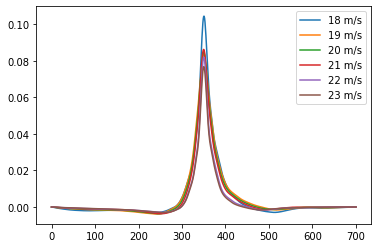

In [3]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(18,24):
    plt.plot(func1D(i),label=str(i)+" m/s")
plt.legend()
plt.show()

In [4]:
def get_poids_Stats2(se_Poids,func1D,decalage = None):
    """
        Prend comme paramètre le sous ensemble de poids et la fonction interp LI/Vitesses
        Retourne la liste des poids estimés pour ces camions
    """
    import numpy as np
    from Bwifsttar import find_best_peaks,estimation_peaks,find_best_position_locale,get_position_decalage_stats
    
    print("********** Working on weights... **********")
    list_poids = []
    for i,truck in enumerate(se_Poids):
        try:
            if(decalage=='combinaisons'):

                dec = find_best_position_locale(truck,2,func1D)
                w = estimation_peaks(truck,dec, func1D(truck.speed))
            elif(decalage=='On_peak'):
                dec = get_position_decalage_stats(truck,func1D)
                w = estimation_peaks(truck,dec, func1D(truck.speed))      
            else :
                w = estimation_peaks(truck,truck.peaks, func1D(truck.speed)) 
        except:
            continue
        list_poids.append(w)
    list_poids = np.array(list_poids)
    return list_poids


In [6]:
import numpy as np
from Bwifsttar import get_SE_Stats,get_LI_Stats,get_erreur_essieu,get_metrics

list_erreur_tot_moy = []
list_erreur_essieu_moy = np.zeros(5)
list_percent_erreur_moy_tot = []
list_percent_erreur_essieu = np.zeros(5)
list_erreurs_tot = []
list_erreurs_tot_redr = []
list_erreur_essieu1 = []
list_erreur_essieu2 = []
list_erreur_essieu3 = []
list_erreur_essieu4 = []
list_erreur_essieu5 = []

list_percent_tot = []
list_trucks_anormaux = []


trucks = [truck for truck in calibration_trucks if(len(truck.weights)==len(truck.peaks))]
trucks_t2 = [truck for truck in traffic_trucks if(len(truck.weights)==len(truck.peaks))]
for truck in trucks:
    trucks_t2.append(truck)
trucks_t2 = [truck for i,truck in enumerate(trucks_t2) if truck.speed!=25.18025490149026]
se2=trucks_t2

func= func1D

poids_estimes = get_poids_Stats2(se2,func1D,'On_peak')
#poids_estimes = get_poids_Stats2(se2,func1D)

scores,scores_totaux = get_erreur_essieu(se2,poids_estimes)
erreur_tot_moy,list_percent_err_poids_tot,percent_err_moy,list_err_moy_essieux,list_percent_moy_essieux = get_metrics(scores,scores_totaux,se2)
for a,j in enumerate(poids_estimes):
    print("ERREUR : ",np.sum(j)-np.sum(se2[a].weights))

    #if(((np.sum(j)-np.sum(se2[a].weights)) > 20) or ((np.sum(j)-np.sum(se2[a].weights ))< -20) ):
    
    try:
        list_erreurs_tot.append(np.sum(j)-np.sum(se2[a].weights))

        list_erreurs_tot_redr.append(abs(np.sum(j)-np.sum(se2[a].weights)))

        list_percent_tot.append(100*(list_erreurs_tot[a]/np.sum(se2[a].weights)))
    except:
        continue
#print(1-100*(list_erreurs_tot[a]/np.sum(se2[a].weights)))
    try:
        for a,j in enumerate(poids_estimes.T[0]):
            try:
                list_erreur_essieu1.append(j-se2[a].weights[0])
            except:
                continue
        for a,j in enumerate(poids_estimes.T[1]):
            try:
                list_erreur_essieu2.append(j-se2[a].weights[1])
            except:
                continue

        for a,j in enumerate(poids_estimes.T[2]):
            try:
                list_erreur_essieu3.append(j-se2[a].weights[2])
            except:

                continue
        for a,j in enumerate(poids_estimes.T[3]):
            try:
                list_erreur_essieu4.append(j-se2[a].weights[3])
            except:
                continue
        for a,j in enumerate(poids_estimes.T[4]):
            try:
                list_erreur_essieu5.append(j-se2[a].weights[4])
            except:
                continue
    except:
        pass
    np.save("Errors/erreurs_dec/best_perfs_to_compare/erreurs_tot.npy",list_erreurs_tot)
    np.save("Errors/erreurs_dec/best_perfs_to_compare/erreurs_tot_redr.npy",list_erreurs_tot_redr)
    np.save("Errors/erreurs_dec/best_perfs_to_compare/erreur_essieu1.npy",list_erreur_essieu1)
    np.save("Errors/erreurs_dec/best_perfs_to_compare/erreur_essieu2.npy",list_erreur_essieu2)
    np.save("Errors/erreurs_dec/best_perfs_to_compare/erreur_essieu3.npy",list_erreur_essieu3)
    np.save("Errors/erreurs_dec/best_perfs_to_compare/erreur_essieu4.npy",list_erreur_essieu4)
    np.save("Errors/erreurs_dec/best_perfs_to_compare/erreur_essieu5.npy",list_erreur_essieu5)

list_erreur_tot_moy.append(erreur_tot_moy)

list_percent_erreur_moy_tot.append(percent_err_moy)

list_erreurs_tot=np.array(list_erreurs_tot)
list_erreurs_tot_redr=np.array(list_erreurs_tot_redr)
list_erreur_essieu1=np.array(list_erreur_essieu1)
list_erreur_essieu2=np.array(list_erreur_essieu2)
list_erreur_essieu3=np.array(list_erreur_essieu3)
list_erreur_essieu4=np.array(list_erreur_essieu4)
list_erreur_essieu5=np.array(list_erreur_essieu5)

********** Working on weights... **********
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage trouvé
Décalage tro

<ipython-input-4-8249babc6db1>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_poids = np.array(list_poids)


In [21]:
somme = 0
for truck in trucks_t2:
    somme += np.sum(truck.weights)
print(somme/len(trucks_t2))

41.929923333333335
